# <center>Varun_Kumar(142002018)</center>

# <center>AI for Cybersecurity</center>

## Spam Classifier using Email Data from TREC 2007 Public Corpus for classifying emails as Spam / Ham

## Problem Statement
In this assignment, you are going to build your own custom spam detection system. Assume
that you are working as security engineer at some organization and you are asked to solve
the problem of rampant email spam affecting employees in the organization. For whatever
reason, you are instructed to develop a custom solution instead of using commercial options.
Provided with administrator access to the private email servers, you can extract a body of
emails for analysis. All the emails are properly tagged by recipients as either “spam” or “ham”
(non-spam), so you do not need to spend too much time cleaning the data.
An intuitive method to deal with this problem is to scan through all the email messages and
check for words which are very often used by spam messages. There is a pattern associated
with spam messages. If an email contains such words, then you can identify or classify it as a
spam otherwise as ham. For instance, you notice that the word “lottery” appears in the spam
data a lot, but seldom appears in regular emails.
Before using any known Machine Learning models, you are required to first develop a naïve
algorithm which will classify a message between spam or ham using a “blacklist” of words.

## Importing the necessary libraries

In [1]:
import numpy as np
import re
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
import seaborn as sns
import pandas as pd
from bs4 import BeautifulSoup
import os
from pathlib import Path

## loading dataset

In [2]:
data=pd.read_csv("full/index",sep=' ',header=None)
data.head()

0                 1
0  spam  ../data/inmail.1
1   ham  ../data/inmail.2
2  spam  ../data/inmail.3
3  spam  ../data/inmail.4
4  spam  ../data/inmail.5

In [3]:
data.columns=['class','filepath']

In [4]:
data['contents']=None
data.head()

class          filepath contents
0  spam  ../data/inmail.1     None
1   ham  ../data/inmail.2     None
2  spam  ../data/inmail.3     None
3  spam  ../data/inmail.4     None
4  spam  ../data/inmail.5     None

In [5]:
category={'spam':1,'ham':0}
data['class']=[category[item] for item in data['class'] ]
data.head()

class          filepath contents
0      1  ../data/inmail.1     None
1      0  ../data/inmail.2     None
2      1  ../data/inmail.3     None
3      1  ../data/inmail.4     None
4      1  ../data/inmail.5     None

In [6]:
import re
import string
    
for i,row in data.iterrows():
    
    filepath=os.path.join(os.getcwd(),row['filepath'].replace('../',''))
    with open(filepath, 'rb') as f:
        email_txt = f.read()
        email_text=str(email_txt)
        if i<2:
            print(email_txt)
        
    data.at[i,'contents']= email_txt
        
print(data.head())
print(data.info())

b'From RickyAmes@aol.com  Sun Apr  8 13:07:32 2007\nReturn-Path: <RickyAmes@aol.com>\nReceived: from 129.97.78.23 ([211.202.101.74])\n\tby speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;\n\tSun, 8 Apr 2007 13:07:21 -0400\nReceived: from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100\nMessage-ID: <WYADCKPDFWWTWTXNFVUE@yahoo.com>\nFrom: "Tomas Jacobs" <RickyAmes@aol.com>\nReply-To: "Tomas Jacobs" <RickyAmes@aol.com>\nTo: the00@speedy.uwaterloo.ca\nSubject: Generic Cialis, branded quality@ \nDate: Sun, 08 Apr 2007 21:00:48 +0300\nX-Mailer: Microsoft Outlook Express 6.00.2600.0000\nMIME-Version: 1.0\nContent-Type: multipart/alternative;\n\tboundary="--8896484051606557286"\nX-Priority: 3\nX-MSMail-Priority: Normal\nStatus: RO\nContent-Length: 988\nLines: 24\n\n----8896484051606557286\nContent-Type: text/html;\nContent-Transfer-Encoding: 7Bit\n\n<html>\n<body bgcolor="#ffffff">\n<div style="border-color: #00FFFF; border-right-width: 0px; border-bottom-width: 

In [7]:
data.head()

class          filepath                                           contents
0      1  ../data/inmail.1  b'From RickyAmes@aol.com  Sun Apr  8 13:07:32 ...
1      0  ../data/inmail.2  b'From bounce-debian-mirrors=ktwarwic=speedy.u...
2      1  ../data/inmail.3  b'From 7stocknews@tractionmarketing.com  Sun A...
3      1  ../data/inmail.4  b'From vqucsmdfgvsg@ruraltek.com  Sun Apr  8 1...
4      1  ../data/inmail.5  b'From dcube@totalink.net  Sun Apr  8 13:19:30...

In [8]:
data.drop(['filepath'],axis=1,inplace=True)

In [9]:
data.head()

class                                           contents
0      1  b'From RickyAmes@aol.com  Sun Apr  8 13:07:32 ...
1      0  b'From bounce-debian-mirrors=ktwarwic=speedy.u...
2      1  b'From 7stocknews@tractionmarketing.com  Sun A...
3      1  b'From vqucsmdfgvsg@ruraltek.com  Sun Apr  8 1...
4      1  b'From dcube@totalink.net  Sun Apr  8 13:19:30...

## plot number of lables

<AxesSubplot:xlabel='class', ylabel='count'>

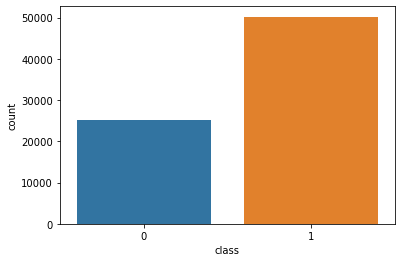

In [10]:
sns.countplot(x="class",data=data)

# <h2> Preprocessing of Text </h2>

# - Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords

In [11]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class     75419 non-null  int64 
 1   contents  75419 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


## Delete all the duplicates rows

In [13]:
#Deduplication of entries
data=data.drop_duplicates(subset={"class","contents"}, keep='first', inplace=False)
data.shape

(75419, 2)

In [14]:
data['contents']  = data['contents'] .fillna("").apply(preprocess)

In [15]:
data.head()

class                                           contents
0      1  b from rickyames aol com  sun apr  8 13 07 32 ...
1      0  b from bounce debian mirrors ktwarwic speedy u...
2      1  b from 7stocknews tractionmarketing com  sun a...
3      1  b from vqucsmdfgvsg ruraltek com  sun apr  8 1...
4      1  b from dcube totalink net  sun apr  8 13 19 30...

## wordcloud


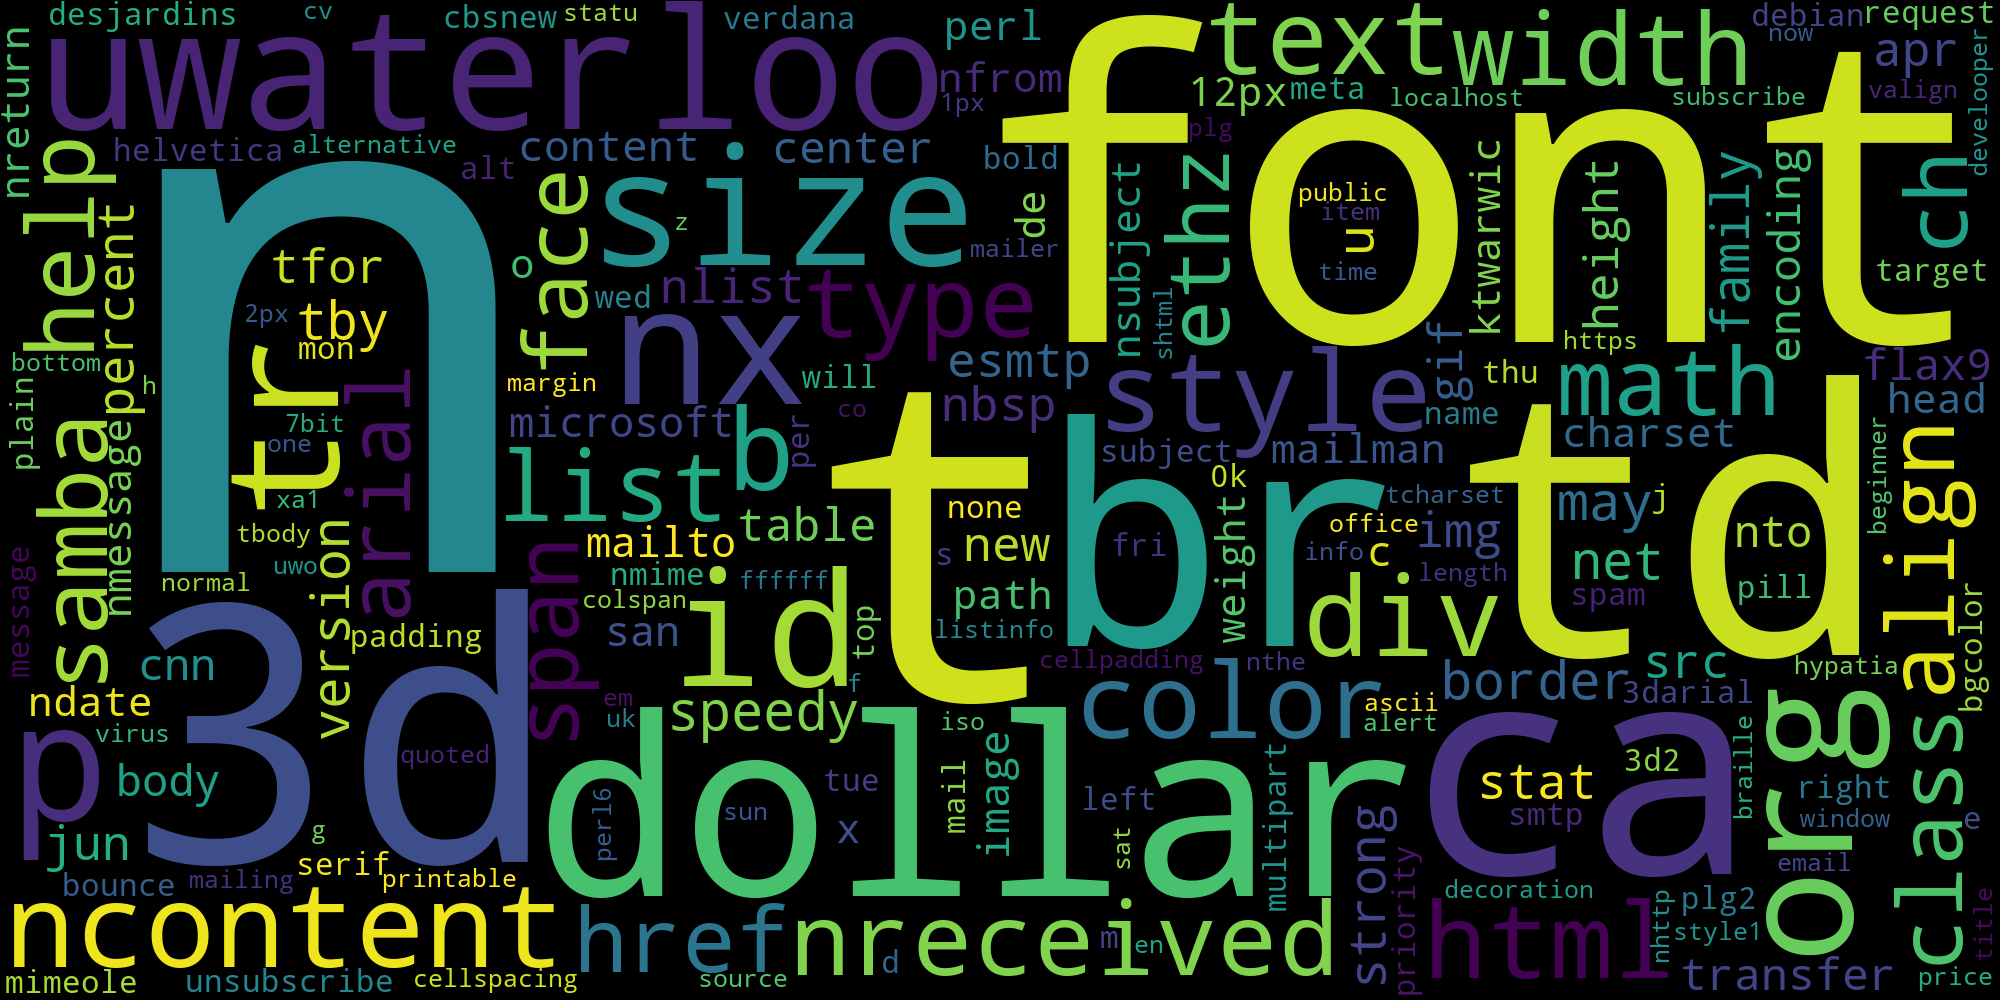

In [16]:
from wordcloud import WordCloud
import plotly.express as px
def nonan(x):
    if type(x) == str:
        return x.replace("\n", "")
    else:
        return ""

text = ' '.join([nonan(abstract) for abstract in data["contents"]])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=2000, height=1000).generate(text)
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments')

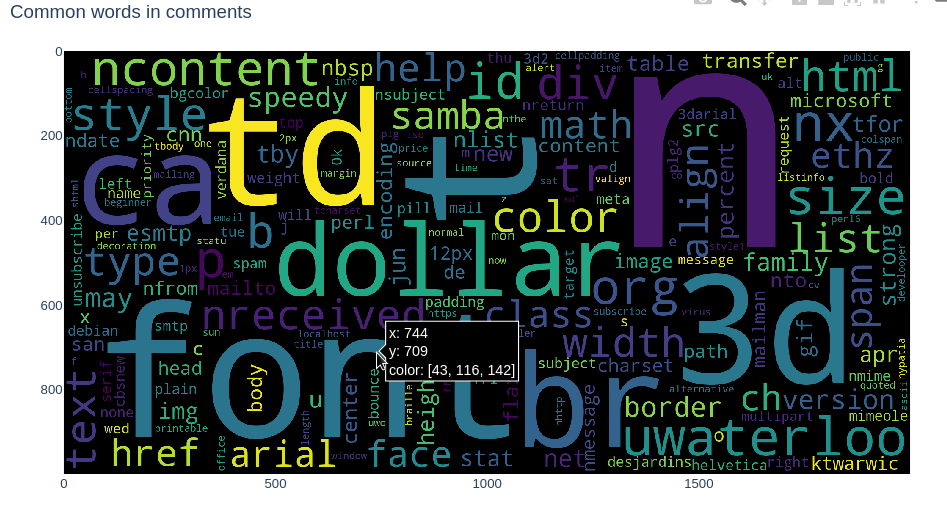

In [17]:
from IPython.display import Image
Image("wordcloud.png")

In [18]:
X = data.drop(['class'], axis=1)
y = data['class'].values
X.head(1)

contents
0  b from rickyames aol com  sun apr  8 13 07 32 ...

# Split dataset train and test 70:30 ratio

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

## Apply TF-IDF nlp algo to covert words to vectors

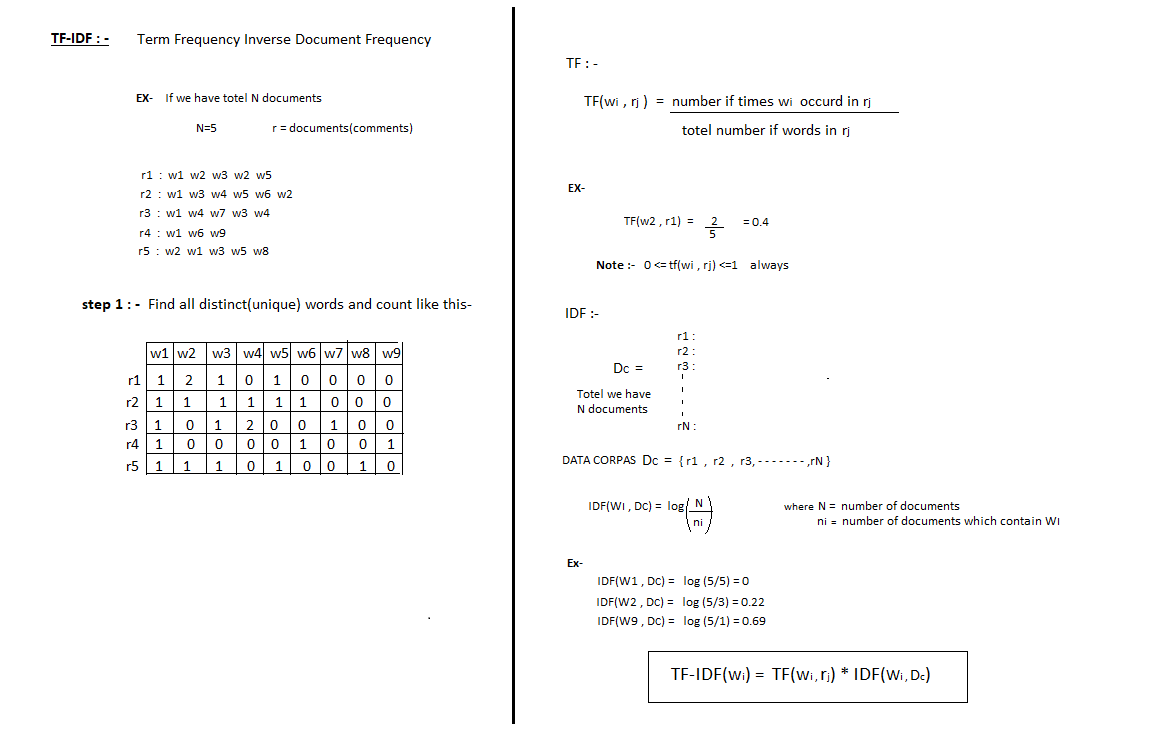

In [20]:
Image("project.png")

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

In [22]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['contents'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train = vectorizer.transform(X_train['contents'].values)
X_test = vectorizer.transform(X_test['contents'].values)


In [23]:
X_train.shape

(52793, 2917859)

In [24]:
X_test.shape

(22626, 2917859)

## apply Decision tree to binary classification

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision      1.0      1.0       1.0        1.0           1.0
recall         1.0      1.0       1.0        1.0           1.0
f1-score       1.0      1.0       1.0        1.0           1.0
support    17663.0  35130.0       1.0    52793.0       52793.0
_______________________________________________
Confusion Matrix: 
 [[17663     0]
 [    0 35130]]

Test Result:
Accuracy Score: 99.80%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.996563      0.998739  0.998011      0.997651      0.998012
recall        0.997486      0.998275  0.998011      0.997880      0.998011
f1-score      0.997024      0.998507  0.998011      0.997765      0.998011
support    7557.000000  15069.000000  0.998011  22626.000000  22626.0

## apply SVM to binary classification

In [27]:
from sklearn.svm import SVC
svc = SVC(kernel='sigmoid')
svc.fit(X_train, y_train)
prediction = svc.predict(X_test)
print_score(svc, X_train, y_train, X_test, y_test, train=True)
print_score(svc, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.83%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.997847      0.998464  0.998257      0.998155      0.998257
recall         0.996943      0.998918  0.998257      0.997931      0.998257
f1-score       0.997395      0.998691  0.998257      0.998043      0.998257
support    17663.000000  35130.000000  0.998257  52793.000000  52793.000000
_______________________________________________
Confusion Matrix: 
 [[17609    54]
 [   38 35092]]

Test Result:
Accuracy Score: 99.74%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.997347      0.997481  0.997437      0.997414      0.997436
recall        0.994972      0.998673  0.997437      0.996822      0.997437
f1-score      0.996158      0.998077  0.997437      0.997117      0.997436
suppo

## apply naive_bayes to binary classification

In [28]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB(alpha=0.2)
mnb.fit(X_train, y_train)
prediction = mnb.predict(X_test)
print_score(mnb, X_train, y_train, X_test, y_test, train=True)
print_score(mnb, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.46%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.992015      0.995845  0.994564      0.993930      0.994563
recall         0.991734      0.995986  0.994564      0.993860      0.994564
f1-score       0.991875      0.995915  0.994564      0.993895      0.994563
support    17663.000000  35130.000000  0.994564  52793.000000  52793.000000
_______________________________________________
Confusion Matrix: 
 [[17517   146]
 [  141 34989]]

Test Result:
Accuracy Score: 99.49%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.998126      0.993270  0.994873      0.995698      0.994892
recall        0.986503      0.999071  0.994873      0.992787      0.994873
f1-score      0.992280      0.996162  0.994873      0.994221      0.994866
suppo